# Cardiovascular model

In [1]:
import torch

import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np

plt.rcParams['figure.figsize'] = [4,4]

## Load in data

The data used for the following experiment may be obtained from [here](https://github.com/lazarusal/LV-paper-code).

In [5]:
pd_train_X = pd.read_csv("LV-paper-code/data_csv_files/Parameters_training_new.csv", header=None)
pd_train_Y = pd.read_csv("LV-paper-code/data_csv_files/Standardised_training_new.csv", header=None)

pd_test_X = pd.read_csv("LV-paper-code/data_csv_files/Parameters_test_new.csv", header=None)
pd_test_Y = pd.read_csv("LV-paper-code/data_csv_files/Standardised_test_new.csv", header=None)

X_train = torch.Tensor(pd_train_X.values)
Y_train = torch.Tensor(pd_train_Y.values).T[-1]

X_test = torch.Tensor(pd_test_X.values)
Y_test = torch.Tensor(pd_test_Y.values).T[-1]


## Define black-box target

In [6]:
def black_box(x):
    if x.dim() > 1:
        xt = x.unsqueeze(1)
        dists = torch.norm(xt - X_train, dim=2)
    else:
        xt = x
        dists = torch.norm(xt - X_train, dim=1)
    
    nearest_index = torch.topk(dists, 1, largest=False)[1]
    return Y_train[nearest_index].flatten()

## Define ANOVA kernel

An ANOVA kernel takes the form

$$ k(x,y) =  \sum_{I \in D} w_I k_I(x_I,y_I), $$

where $D \subseteq \bigcup_{i=1}^d \{(j_1,\ldots,j_i) \subseteq \mathbb{Z}^i\,|\, 1\leq j_1 <\ldots< j_i\leq d \}$, $w_I\in\mathbb{R}$ are constants, $k_I:\mathbb{R}^{|I|}\times\mathbb{R}^{|I|}\rightarrow\mathbb{R}$ is an arbitrary kernel capturing the interactions between the dimensions $I$ and $x_I = (x_{j_1},\ldots,x_{j_i})$ and $y_I = (y_{j_1},\ldots,y_{j_i})$
where$D = \bigcup_{i=1}^d \{(j_1,\ldots,j_i) \subseteq \mathbb{Z}^i\,|\, 1\leq j_1 <\ldots< j_i\leq d \}$, $w_I\in\mathbb{R}$ are constants, $k_I:\mathbb{R}^{|I|}\times\mathbb{R}^{|I|}\rightarrow\mathbb{R}$ is an arbitrary kernel capturing the interactions between the dimensions $I$ and $x_I = (x_{j_1},\ldots,x_{j_i})$ and $y_I = (y_{j_1},\ldots,y_{j_i})$. Since, in GaussED, the individual kernels making up the composite ANOVA kernel each have a different amplitude parameter, the weight parameters $w_I$ would induce an over-parameterisation and thus are not implemented.

In order to specify the kernel fully we specify the interacting dimensions $D$ and the corresponding number of  basis functions to use for each subkernel. Recall that for an $n$-dimensional kernel with $m$ basis functions in each dimension, the total number of basis functions is $m^n$. Thus the total number of basis functions used in ANOVA kernel can be easily computed.

In [7]:
interacting_dims = [[0],[1],[2],[3],[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0,1,2],[0,1,3],[0,2,3],[1,2,3],[0,1,2,3]]
m_list = [25,25,25,25,7,7,7,7,7,7,2,2,2,2,2]  # number of basis functions in each dimension for each kernel
m_simple_list = [25,25,25,25,5,5,5,5,5,5,2,2,2,2,2] 

total_basis_functions = 0

for i in range(len(interacting_dims)):
    total_basis_functions += m_list[i] ** len(interacting_dims[i])

print("Total number of basis functions: ", total_basis_functions)

Total number of basis functions:  442


## Define GP

The following ``optional_func`` updates the kernel parameters of the GP with the function of the charactersitic lengthscales ``char_L``:
$$
   \ell_I \coloneqq \sqrt{\sum_{i \in I} (\ell_i)^2 }.
$$

In [8]:
from gaussed.kernel import AnovaKernel, MaternKernel, PartialAnovaKernel

kernel_list = []

char_L = torch.Tensor([0.3,0.3,0.3,0.3]).unsqueeze(1).requires_grad_(True) 

def optional_func():
    gp.kernel.parameters[1::2] = [char_L[i].norm().unsqueeze(0) for i in interacting_dims]
    for i in range(len(interacting_dims)):
        gp.kernel.kernels[i].parameters[1] = char_L[interacting_dims[i]].norm().unsqueeze(0)
        
for i in range(len(interacting_dims)):
    matern_kernel = MaternKernel(2.5, dim=len(interacting_dims[i]), parameters=[load_output("cardio_experiment_step_i", "Output")[3][0::2][i], torch.Tensor([0.3]).requires_grad_(True)])
    kernel_list.append(matern_kernel)

anova_kernel = PartialAnovaKernel(kernel_list, interacting_dims) #  PartialAnovaKernel(kernel_list, interacting_dims)

In [9]:
from gaussed.distribution import SpectralGP

gp = SpectralGP(anova_kernel)
gp.set_domain(torch.Tensor([[0,5.1],[0,5.1],[0,5.1],[0,5.1]])) # Since the domain of the evaluations are on [0.1, 5]^4, we define the domain to be slightly larger
optional_func()

## Condition on all of test data

In [10]:
phi_mat = gp.basis_matrix(X_train, m_list)
mean, covariance_matrix = gp.condition(phi_mat, Y_train, nugget=29, m=m_list)

In [11]:
mean_func = gp.get_mean(mean, m=m_list)

Y_pred = mean_func(X_test)

all_mse = torch.mean((Y_pred - Y_test).pow(2))

In [12]:
all_mse

tensor(0.0209, grad_fn=<MeanBackward0>)

In [13]:
load_output("cardio_experiment_step_i", "Output") [2]

tensor([27.5710], requires_grad=True)

## Experimental Design

In [13]:
from gaussed.experiment import BayesRisk, EvaluationDesign, L2, Experiment
from gaussed.solver.optim.base import DefaultOptimiser


x = torch.linspace(0.1,5,5)
X1,X2,X3,X4 = torch.meshgrid(x,x,x,x)
mesh_4D = torch.stack([X1,X2,X3,X4]).T.reshape(X1.shape[0]**4,4)

loss = L2(gp, mesh_4D)

init_design = torch.Tensor([[0,0,0,0]])

noise_variance = torch.Tensor([1]).requires_grad_(True)

design = EvaluationDesign(gp, init_design) 

def transformed_black_box(x):
    xt = design.transform(x)
    return black_box(xt)

acquisition = BayesRisk(gp, loss, design, nugget=noise_variance)

def hyper_reg(λ):
    return λ * (1 / torch.cat([char_L[i].norm().unsqueeze(0) for i in interacting_dims])).max().pow(2)

def amp_reg(μ):
    return μ * torch.cat(gp.kernel.parameters[0::2]).exp().norm()

def hyper_obj(a, b, solver=None, nugget=None, λ=0.0001, μ=5):
    return - gp.log_likelihood(a, b, solver=solver, nugget=nugget, m=experiment.m) + hyper_reg(λ) + amp_reg(μ)

hyper_obj_params = {"solver": acquisition.solver, "nugget": noise_variance}
hyper_optim_params = {"lr":1e-3}
hyper_optim = DefaultOptimiser(hyper_obj, torch.optim.Adam, [char_L] + gp.kernel.parameters[0::2] + [noise_variance], objective_params=hyper_obj_params, optimiser_params=hyper_optim_params) 
hyper_optim.set_optional_func(optional_func)

experiment = Experiment(gp, transformed_black_box, design, acquisition, m=m_simple_list, hyper_optim=hyper_optim)

experiment.acq_optim.set_optional_func(optional_func)
experiment.acq_optim.N = 200
experiment.start_hyp_optimising_step = 100
experiment.hyper_optim_steps = 100
experiment.acq_optim_steps = 600

In [ ]:
for i in range(400):
    if i % 5 == 0:
        print("Step ", i, "/ 400")
        print([i.detach() for i in gp.kernel.parameters[0::2]])
    print([i.detach() for i in gp.kernel.parameters[0::2]])
    experiment.run(1)
    save_output([experiment.current_design, char_L.clone().detach(), noise_variance, gp.kernel.parameters], "cardio_experiment_step_i", "Output")

In [ ]:
# Started at 12pm on 13/10

experiment.run(50, print_step=True, optimise_hyper=False)
save_output(experiment.current_design, "cardio_experiment_50", "Output")
print("Sqrt nugget:", acquisition.solver.sqrt_nugget, ". Inverse Nugget:",  acquisition.solver.inverse_nugget)
experiment.run(50, print_step=True, optimise_hyper=False)
save_output(experiment.current_design, "cardio_experiment_100", "Output")

for i in range(900):
    if i % 5 == 0:
        print("Step ", i, "/900")
    experiment.run(1)
    save_output([experiment.current_design, char_L.clone().detach()], "cardio_experiment_step_i", "Output")

Step  1 / 50
Finished acquisition optimistion
Design point:  tensor([ 3.7780e-03,  1.0595e+00,  4.3834e+00, -1.0204e+00],
       requires_grad=True)
Step  2 / 50
Finished acquisition optimistion
Design point:  tensor([ 0.0040, -1.0166,  1.0763,  1.0942], requires_grad=True)
Step  3 / 50
Finished acquisition optimistion
Design point:  tensor([ 1.0808, -1.0268,  4.5683,  0.0104], requires_grad=True)
Step  4 / 50
Finished acquisition optimistion
Design point:  tensor([-1.0762,  0.0497, -1.0530, -0.0330], requires_grad=True)
Step  5 / 50
Finished acquisition optimistion
Design point:  tensor([ 1.0353, -1.0997,  4.5582,  1.0377], requires_grad=True)
Step  6 / 50
Finished acquisition optimistion
Design point:  tensor([-1.0555,  0.0174,  1.0143, -4.1295], requires_grad=True)
Step  7 / 50
Finished acquisition optimistion
Design point:  tensor([ 1.0599, -1.0645,  0.0555, -1.0280], requires_grad=True)
Step  8 / 50
Finished acquisition optimistion
Design point:  tensor([-1.0646,  1.0372, -1.0349,

## Condition on all of test data

## Get MSE for SED

In [63]:
noise_variance

tensor([27.6710], requires_grad=True)

In [14]:
design_ = EvaluationDesign(gp)

def get_true_design(design):
    x_coords = design_.transform(design).unsqueeze(1)

    dists = torch.norm(x_coords - X_train, dim=2)
    nearest_index = torch.topk(dists, 1, largest=False,sorted=True)[1]
    return design_.inverse_transform(X_train[nearest_index]).squeeze(1)

In [25]:
mse_list = []

true_exp = design.transform(get_true_design(experiment.current_design))

rando_index = torch.randperm(len(X_train))[:89] 
X_rando = X_train[rando_index]

true_design = torch.cat([true_exp, X_rando])

print(true_design)
true_Y = black_box(true_design)

for i in range(998,1000):
    phi_mat = gp.basis_matrix(true_design[:i+1], m=m_list)
    mean_i, cov_i = gp.condition(phi_mat, true_Y[:i+1], nugget=6, m=m_list)
    mean_func = gp.get_mean(mean_i, m=m_list)
    Y_pred = mean_func(X_test)
    mse_list.append(torch.mean((Y_pred - Y_test).pow(2)))
    

tensor([[2.4289, 2.6149, 2.4205, 2.8254],
        [2.5324, 3.7221, 4.8855, 1.4156],
        [2.7453, 1.2984, 3.6198, 4.1073],
        ...,
        [4.1073, 1.2380, 3.5582, 3.0085],
        [1.1907, 2.7860, 1.2828, 0.6661],
        [0.7023, 4.8678, 1.4967, 0.5420]])


In [41]:
mse_list = []

true_exp = design.transform(experiment.current_design) # design.transform(get_true_design(experiment.current_design))

#rando_index = torch.randperm(len(X_train))[:110] 
#X_rando = X_train[rando_index]

true_design = torch.cat([true_exp, X_rando])

print(true_design)
true_Y = black_box(true_design)

for i in range(1000):
    phi_mat = gp.basis_matrix(true_design[:i+1], m=m_list)
    mean_i, cov_i = gp.condition(phi_mat, true_Y[:i+1], nugget=noise_variance, m=m_list)
    mean_func = gp.get_mean(mean_i, m=m_list)
    Y_pred = mean_func(X_test)
    mse_list.append(torch.mean((Y_pred - Y_test).pow(2)))
    

tensor([[2.5500, 2.5500, 2.5500, 2.5500],
        [2.5548, 3.7872, 5.0371, 1.3512],
        [2.5551, 1.3550, 3.8035, 3.8208],
        ...,
        [3.7495, 4.5034, 3.1774, 4.8379],
        [0.5186, 3.8087, 1.5338, 1.0887],
        [2.6462, 2.1581, 0.6262, 3.8025]])


In [42]:
mse_list[-1]

tensor(0.0658, grad_fn=<MeanBackward0>)

In [83]:
all_mse

tensor(0.0209, grad_fn=<MeanBackward0>)

In [28]:
uniform = torch.distributions.Uniform(torch.Tensor([0.1,0.1,0.1,0.1]),torch.Tensor([5,5,5,5]))

N = 5

mse_rando_list_of_lists = [[] for j in range(N)]

X_rando = uniform.sample((1000,))
Y_rando = black_box(X_rando)

for j in range(N):
    X_rando = uniform.sample((1000,))
    Y_rando = black_box(X_rando)
    for i in range(1000):
        phi_mat = gp.basis_matrix(X_rando[:i+1], m=m_list)
        mean_i, cov_i = gp.condition(phi_mat, Y_rando[:i+1], nugget=noise_variance, m=m_list)
        mean_func = gp.get_mean(mean_i, m=m_list)
        Y_pred = mean_func(X_test)
        mse_rando_list_of_lists[j].append(torch.mean((Y_pred - Y_test).pow(2)))
    

In [29]:
len(mse_rando_list_of_lists[1])

1000

In [101]:
del mse_rando_list_of_lists

In [79]:
save_output(rando, "random_cardiac","Output")

saved output  random_cardiac  to  D:\Users\Python\GAED project\Output


In [38]:
rando = torch.stack([torch.Tensor(mse_rando_list_of_lists[i]) for i in range(5)])#.clone()

In [31]:
rando2 = load_output("random_cardiac","Output")

In [39]:
rando

tensor([[1.0637, 1.0582, 0.9281,  ..., 0.0511, 0.0511, 0.0511],
        [1.0042, 1.0025, 0.9883,  ..., 0.0453, 0.0454, 0.0455],
        [1.0565, 1.0282, 0.9986,  ..., 0.0655, 0.0655, 0.0652],
        [1.0545, 1.0476, 1.0467,  ..., 0.0613, 0.0613, 0.0614],
        [1.0634, 1.0689, 1.0598,  ..., 0.0430, 0.0429, 0.0429]])

In [36]:
rando2

tensor([[1.0644, 1.0641, 1.0586,  ..., 0.0467, 0.0468, 0.0469],
        [1.0380, 1.0323, 1.0093,  ..., 0.0561, 0.0561, 0.0561],
        [1.0644, 1.0488, 1.0374,  ..., 0.0535, 0.0535, 0.0535],
        [1.0555, 1.0559, 1.0497,  ..., 0.0459, 0.0459, 0.0459],
        [1.0289, 0.9949, 1.0010,  ..., 0.0443, 0.0443, 0.0443]])

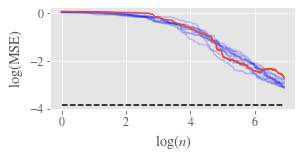

In [43]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [4,2]


plt.plot(torch.cat([torch.log(i + torch.Tensor([1])) for i in range(len(mse_list))]).unsqueeze(-1), torch.log(rando.T), linewidth=1.5, color="blue",alpha=0.2)
plt.plot(torch.cat([torch.log(i + torch.Tensor([1])) for i in range(len(mse_list))]).unsqueeze(-1), torch.log(rando2.T), linewidth=1.5, color="blue",alpha=0.2)
plt.plot(torch.cat([torch.log(i + torch.Tensor([1])) for i in range(len(mse_list))]), torch.log(torch.cat([i.unsqueeze(0) for i in mse_list]).detach()), linewidth=1.5)
plt.hlines(all_mse.detach().log(),0,torch.cat([torch.log(i + torch.Tensor([1])) for i in range(len(mse_list))])[-1], linestyle="dashed", color="black")
plt.xlabel("$\log(n)$")
plt.ylabel("$\log($MSE$)$")

plt.tight_layout(pad=0, w_pad=0.5, h_pad=0.5)
plt.savefig('cardio_error_plot.pdf',bbox_inches = 'tight',pad_inches = 0)
plt.show()

In [92]:
torch.cat([torch.log(i + torch.Tensor([1])) for i in range(len(mse_list))]).unsqueeze(-1)

tensor([[0.0000],
        [0.6931],
        [1.0986],
        [1.3863],
        [1.6094],
        [1.7918],
        [1.9459],
        [2.0794],
        [2.1972],
        [2.3026],
        [2.3979],
        [2.4849],
        [2.5649],
        [2.6391],
        [2.7081],
        [2.7726],
        [2.8332],
        [2.8904],
        [2.9444],
        [2.9957],
        [3.0445],
        [3.0910],
        [3.1355],
        [3.1781],
        [3.2189],
        [3.2581],
        [3.2958],
        [3.3322],
        [3.3673],
        [3.4012],
        [3.4340],
        [3.4657],
        [3.4965],
        [3.5264],
        [3.5553],
        [3.5835],
        [3.6109],
        [3.6376],
        [3.6636],
        [3.6889],
        [3.7136],
        [3.7377],
        [3.7612],
        [3.7842],
        [3.8067],
        [3.8286],
        [3.8501],
        [3.8712],
        [3.8918],
        [3.9120],
        [3.9318],
        [3.9512],
        [3.9703],
        [3.9890],
        [4.0073],
        [4

In [162]:
torch.cat([torch.log(i + torch.Tensor([1])) for i in range(len(mse_list))])

tensor([0.0000, 0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459, 2.0794, 2.1972,
        2.3026, 2.3979, 2.4849, 2.5649, 2.6391, 2.7081, 2.7726, 2.8332, 2.8904,
        2.9444, 2.9957, 3.0445, 3.0910, 3.1355, 3.1781, 3.2189, 3.2581, 3.2958,
        3.3322, 3.3673, 3.4012, 3.4340, 3.4657, 3.4965, 3.5264, 3.5553, 3.5835,
        3.6109, 3.6376, 3.6636, 3.6889, 3.7136, 3.7377, 3.7612, 3.7842, 3.8067,
        3.8286, 3.8501, 3.8712, 3.8918, 3.9120, 3.9318, 3.9512, 3.9703, 3.9890,
        4.0073, 4.0254, 4.0431, 4.0604, 4.0775, 4.0943, 4.1109, 4.1271, 4.1431,
        4.1589, 4.1744, 4.1897, 4.2047, 4.2195, 4.2341, 4.2485, 4.2627, 4.2767,
        4.2905, 4.3041, 4.3175, 4.3307, 4.3438, 4.3567, 4.3694, 4.3820, 4.3944,
        4.4067, 4.4188, 4.4308, 4.4427, 4.4543, 4.4659, 4.4773, 4.4886, 4.4998,
        4.5109, 4.5218, 4.5326, 4.5433, 4.5539, 4.5643, 4.5747, 4.5850, 4.5951,
        4.6052, 4.6151, 4.6250, 4.6347, 4.6444, 4.6540, 4.6634, 4.6728, 4.6821,
        4.6913, 4.7005, 4.7095, 4.7185, 